# ASFE21 Part 2: Failure Probability Based Approach

Part 1 of the analysis carried out for the conference paper submitted to ASFE21, "An Improved Reliability-Based Approach to Sepcifying Fire Resistance Periods For Buildings in England"

_2021 May, Ian F._

In [1]:
from os import path
from typing import Callable, Union

import matplotlib.pyplot as plt
# Dependencies
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from scipy import stats
from scipy.interpolate import interp1d

from sfeprapy.mcs2 import MCS2, EXAMPLE_INPUT_DF

%matplotlib inline
plt.style.use('seaborn-paper')

In [2]:
# Helper function: return a function f(fractile) = teq
def make_func_cdf2teq(teq: np.ndarray) -> Callable:
    teq = teq[~np.isnan(teq)]
    max_= np.amax(teq[teq<np.inf])
    hist, edges = np.histogram(teq, bins=np.arange(0, max_, 0.5))
    teq, fractile = (edges[:-1] + edges[1:]) / 2, np.cumsum(hist / np.sum(hist))
    return interp1d(fractile, teq, bounds_error=False)


# Helper function: return a function f(teq) = fractile
def make_func_teq2cdf(teq: np.ndarray) -> Callable:
    teq = teq[~np.isnan(teq)]
    max_= np.amax(teq[teq<np.inf])
    hist, edges = np.histogram(teq, bins=np.arange(0, max_, 0.5))
    teq, fractile = (edges[:-1] + edges[1:]) / 2, np.cumsum(hist / np.sum(hist))
    return interp1d(teq, fractile, bounds_error=False)


def func_A2cdf(A: np.ndarray, beta: np.ndarray, p_1: float, p_2: float, p_3: float, p_4: float):
    """Calculate time equivalence CDF for a given building total floor area and betas.
    
    Solve:
                             P_f_fi = P_a_fi
    p_1 * A * p_2 * p_3 * p_4 * p_5 = P_a_fi(H)
                                p_5 = P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
                        1 - teq_cdf = P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
                            teq_cdf = 1 - P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
    """
    # solve/interpolate teq cdf
    P_a_fi = stats.norm(loc=0, scale=1).cdf(-beta)
    teq_cdf = 1 - np.divide(P_a_fi, p_1 * A * p_2 * p_3 * p_4, dtype=np.float64)
    return teq_cdf

In [3]:
# Helper function: standard figure format
def format_ax(
        ax,
        xlabel: str = None, ylabel: str = None, legend_title: str = None,
        xlabel_fontsize='x-small', ylabel_fontsize='x-small',
        xscale=None, yscale=None,
        xticks=None, yticks=None,
        xticks_minor=None, yticks_minor=None,
        xticklabels=None, yticklabels=None,
        ticks_labelsize='xx-small',
        xlim=None, ylim=None,
        ticklabel_format_style=None, ticklabel_format_axis='y', ticklabel_format_scilimits=(0, 0),
        legend_loc: int = 0, legend_ncol=1, legend_fontsize='xx-small', legend_title_fontsize='xx-small',
        legend_visible: bool = True, legend_borderpad=0.4, legend_labelspacing=0.5,
        grid_which='both', grid_ls='--', grid_lw=.5
):
    if xlabel is not None: ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    if ylabel is not None: ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    if xscale is not None: ax.set_xscale(xscale)
    if yscale is not None: ax.set_yscale(yscale)
    if xticks is not None: ax.set_xticks(xticks)
    if yticks is not None: ax.set_yticks(yticks)
    if xticks_minor is not None: ax.set_xticks(xticks_minor, minor=True)
    if yticks_minor is not None: ax.set_yticks(yticks_minor, minor=True)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)
    if yticklabels is not None: ax.set_yticklabels(yticklabels)
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    if legend_visible is True:
        ax.legend(
            title=legend_title, loc=legend_loc, ncol=legend_ncol, frameon=True, fontsize=legend_fontsize,
            fancybox=False, title_fontsize=legend_title_fontsize, facecolor=(1,1,1,0.5), edgecolor=(0,0,0),
            borderpad=legend_borderpad, labelspacing=legend_labelspacing
        ).set_visible(legend_visible)
    ax.grid(which=grid_which, ls=grid_ls, lw=grid_lw)
    ax.tick_params(labelsize=ticks_labelsize)

    if ticklabel_format_style is not None:
        ax.ticklabel_format(
            style=ticklabel_format_style,
            scilimits=ticklabel_format_scilimits,
            axis=ticklabel_format_axis,
            useMathText=True
        )

    if ticklabel_format_style is not None:
        ax.yaxis.offsetText.set_fontsize('x-small')


def plot_contour(
        ax, xx, yy, zz,
        xticks_minor=None,
        levels=None, clabel_fmt=lambda x: f'{x:.0f}', clabel_manual=False,
        cmap: str = 'Greys', **kwargs
):
    cs = ax.contour(xx, yy, zz, levels=levels, linewidths=0.5, colors='k', linestyles='dotted', antialiased=True)
    cf = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap, alpha=0.6, extend='both')
    ax.clabel(cs, cs.levels, inline=True, fmt=clabel_fmt, fontsize='xx-small', manual=clabel_manual, use_clabeltext=True)
    format_ax(ax=ax, **kwargs)
    if xticks_minor is not None: ax.set_xticks(xticks_minor, minor=True)

    return cf


def plot_contour_text_p_i(ax, title, p_i, x=0.95, y=0.97, va='top', ha='right', bbox_pad=-0.01, bbox_fc=(1, 1, 1, 0.5), fontsize='xx-small', linespacing=1, **kwargs):
    ax.text(
        x, y,
        f'{title}\n'
        f'$p_1$={p_i["p_1"]}\n'
        f'$p_2$={p_i["p_2"]}\n'
        f'$p_3$={p_i["p_3"]}\n'
        f'$p_4$={p_i["p_4"]}',
        transform=ax.transAxes, ha=ha, va=va, ma='left', fontsize=fontsize, linespacing=linespacing,
        bbox=dict(boxstyle=f'square,pad={bbox_pad}', fc=bbox_fc, ec='none'),
        **kwargs
    )


def ax_annotate(
        ax, text, xy, xytext, fontsize='x-small', ha='center', va='bottom', ma='left',
        arrowprops_style='->', arrowprops_lw=.5, arrowprops_lc='k',
        bbox_pad=-0.01, bbox_fc=(1, 1, 1, 0.5), bbox_ec='none'
):
    ax.annotate(
        text, xy=xy, xytext=xytext,
        fontsize=fontsize, ha=ha, va=va, ma=ma,
        arrowprops=dict(arrowstyle=arrowprops_style, lw=arrowprops_lw),
        bbox=dict(boxstyle=f'square,pad={bbox_pad}', fc=bbox_fc, ec=bbox_ec)
    )


# Helper function: print DataFrame in HTML format
def print_df(df: pd.DataFrame):
    display(HTML(df.to_html()))


def savefig(fig, fname, dname='fig', dpi=600, bbox_inches='tight', pad_inches=0.02, *_, **__):
    plt.tight_layout()
    plt.show()
    try:
        fig.savefig(path.join(dname, fname), dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches, *_, **__)
    except:
        pass

## Structural failure probability
### Prepare MCS inputs

In [4]:
# Update inputs to include travelling fire model and other parameters
df_inputs_2 = EXAMPLE_INPUT_DF.copy()
df_inputs_2.loc['n_simulations'] = 10_000  # set to simulation iteration to 100k to make fine plots later
df_inputs_2.loc['solver_thickness_ubound'] = 0.045
df_inputs_2['Retail'].loc['room_floor_area:dist'] = 'constant_'
df_inputs_2['Retail'].loc['room_floor_area:lbound'] = 400.
df_inputs_2['Retail'].loc['room_floor_area:ubound'] = 400.
df_inputs_2.loc['solver_temperature_goal'] = 620 + 273.15

In [5]:
print_df(df_inputs_2)

,Residential,Office,Retail
case_name,,,
n_simulations,10000,10000,10000
fire_time_step,10,10,10
fire_time_duration,18000,18000,18000
fire_hrr_density:dist,uniform_,uniform_,uniform_
fire_hrr_density:lbound,0.32,0.15,0.27
fire_hrr_density:ubound,0.57,0.65,1.0
fire_load_density:dist,gumbel_r_,gumbel_r_,gumbel_r_
fire_load_density:lbound,10,10,10.0
fire_load_density:ubound,1200,1200,2000.0


### Run MCS

In [6]:
# Run MCS
cases_to_run=['Residential', 'Office', 'Retail']
mcs = MCS2(print_stats=False)
mcs.inputs = df_inputs_2
mcs.n_threads = 6
mcs.run_mcs(cases_to_run=cases_to_run)

CASE                    : Residential
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:05<00:00, 1968.03it/s]


CASE                    : Office
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:04<00:00, 2452.21it/s]


CASE                    : Retail
NO. OF THREADS          : 6
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:04<00:00, 2459.49it/s]


### Time equivalence results

In [7]:
# Inspect simulation results
mcs_out = mcs.mcs_out
dict_teq = {case: mcs_out.loc[mcs_out['case_name'] == case]["solver_time_equivalence_solved"] / 60.0 for case in cases_to_run}
dict_teq = {k: v[~np.isnan(v)] for k, v in dict_teq.items()}  # remove np.nan values, non convergency iterations

dict_func_teq2cdf = {k: make_func_teq2cdf(teq=v) for k, v in dict_teq.items()}
dict_func_cdf2teq = {k: make_func_cdf2teq(teq=v) for k, v in dict_teq.items()}

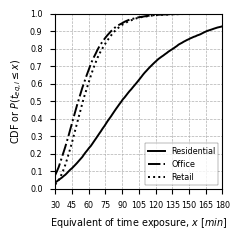

In [8]:
fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=100);
lss = ['-', '-.', 'dotted']
FRs = np.linspace(30, 180, 100)
for i, case in enumerate(cases_to_run):
    ax.plot(FRs, dict_func_teq2cdf[case](FRs), label=case, ls=lss[i], c='k')
format_ax(ax=ax, xlabel='Equivalent of time exposure, $x$ [$min$]', xlabel_fontsize='x-small', xlim=(30, 180), ylabel=r'CDF or $P(t_{eq,i}\leq x)$', ylim=(0, 1), xticks=np.arange(30, 181, 15,), yticks=np.arange(0, 1.1, 0.1))

savefig(fig, 'teq_2.png')

### Comparing against Kirby et al

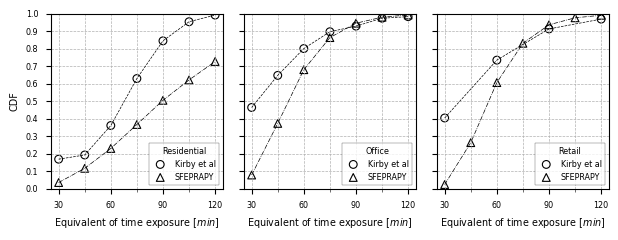

In [9]:
kirby = pd.concat([
    pd.DataFrame({'Residential': [0.169, 0.193, 0.361, 0.629, 0.844, 0.953, 0.991]}, index=[30, 45, 60, 75, 90, 105, 120]),
    pd.DataFrame({'Office':      [0.464, 0.647, 0.800, 0.896, 0.928, 0.973, 0.982]}, index=[30, 45, 60, 75, 90, 105, 120]),
    pd.DataFrame({'Retail':      [0.404,        0.734,        0.912,        0.968]}, index=[30,     60,     90,      120]),
], axis=1)
kirby.index.name = 'teq'

# Compare against Kirby
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.1*3, 2.5), sharex=True, sharey=True, dpi=100)

for i, case in enumerate(cases_to_run):
    ax = axes[i]
    ax.scatter(kirby.index.values, kirby[case].values, label='Kirby et al', marker='o', facecolors='none', edgecolors='k', linewidths=.8)
    ax.plot(kirby.index.values[~np.isnan(kirby[case].values)], kirby[case].values[~np.isnan(kirby[case].values)], ls='--', c='k', lw=.5)
    ax.scatter(kirby.index.values, dict_func_teq2cdf[case](kirby.index.values), label='SFEPRAPY', marker='^', facecolors='none', edgecolors='k', linewidths=.8)
    ax.plot(kirby.index.values, dict_func_teq2cdf[case](kirby.index.values), ls='-.', c='k', lw=.5)
    format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', xlabel_fontsize='x-small', xticks=np.arange(30, 121, 30), xticks_minor=np.arange(30, 121, 15), ylim=(0, 1), yticks=np.arange(0, 1.1, 0.1), legend_title=case, legend_loc=4, legend_fontsize='xx-small', legend_title_fontsize='xx-small')
axes[0].set_ylabel('CDF', fontsize='x-small')

savefig(fig, 'benchmark_2.png')

### $P_{f,fi}$ Failure probabilies due to structurally signification fire

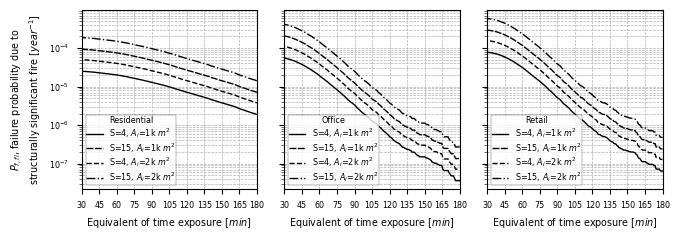

In [10]:
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1),
}

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.3*3, 2.5), sharex=True, sharey=True, dpi=100)
lss = ['-', (0, (5, 1)), '--', '-.', (0, (3, 1, 1, 1)), ':', (0, (5, 10))]
for i, case in enumerate(dict_teq.keys()):
    ax = axes[i]
    t = np.linspace(0, 180, 200)  # x-axis, time
    P_f_fi = 1 - dict_func_teq2cdf[case](t)  # failure probability due to structurally significant fires
    p_fi = np.prod(list(dict_p_i[case].values()))  # probability of structural significant fire occurance
    
    S_and_A = ((4, 800), (15, 800), (4, 1600), (15, 1600)) if case == 'Residential' else ((4, 1000), (15, 1000), (4, 2000), (15, 2000))
    
    for j, (S_, A_) in enumerate(S_and_A):
        ax.plot(t, p_fi * P_f_fi * (S_ * A_), label=f'S={S_:.0f}, $A_i$={A_*1e-3:.0f}k $m^2$', c='k', ls=lss[j], lw=1)
    format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', xlim=(30, 180), xticks=np.arange(30, 181, 15), yscale='log', legend_title=case, legend_ncol=1, legend_loc=3, legend_fontsize='xx-small', legend_borderpad=0.1, legend_labelspacing=0.1)

ax = axes[0]
ax.set_ylabel('$P_{f,fi}$, failure probability due to\nstructurally significant fire [${year}^{-1}$]', fontsize='x-small')

savefig(fig, 'P_f_fi_vs_A.png')

## Recommended fire resistance periods

### Buildings without sprinklers

In [36]:
# define p parameters
dict_p_i_no_sprinklers = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1),
}

# calculate time equivalence
beta, area = np.meshgrid(np.linspace(3.7, 4.4, 1500), np.linspace(1000, 100000, 1500))
teqs_no_sprinklers = dict()
for i, case in enumerate(cases_to_run):
    teq_cdf = func_A2cdf(A=area, beta=beta, **dict_p_i_no_sprinklers[case])
    teq = dict_func_cdf2teq[case](teq_cdf)
    teq[teq_cdf<0] = 0.
    teqs_no_sprinklers[case] = teq

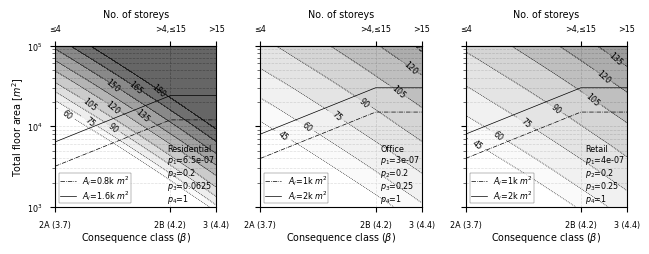

In [37]:
# visualisation, logscale
teqs = teqs_no_sprinklers
dict_p_i = dict_p_i_no_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.65), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)

# plot no sprinklers
for i, key in enumerate(teqs):
    levels = np.arange(60, 181, 15) if key == 'Residential' else np.arange(45, 181, 15)
    ax = axes[i]
    ax.set_yscale('log')

    # add line text
    if key == 'Residential':
        ax.plot([3.7, 4.2, 4.4], [j*800 for j in [4, 15, 15]], c='k', lw=.5, ls='-.', label='$A_i$=0.8k $m^2$')
        ax.plot([3.7, 4.2, 4.4], [j*1600 for j in [4, 15, 15]], c='k', lw=.5, ls='-', label='$A_i$=1.6k $m^2$')
    elif key == 'Office':
        ax.plot([3.7, 4.2, 4.4], [j*1000 for j in [4, 15, 15]], c='k', lw=.5, ls='-.', label='$A_i$=1k $m^2$')
        ax.plot([3.7, 4.2, 4.4], [j*2000 for j in [4, 15, 15]], c='k', lw=.5, ls='-', label='$A_i$=2k $m^2$')
    elif key == 'Retail':
        ax.plot([3.7, 4.2, 4.4], [j*1000 for j in [4, 15, 15]], c='k', lw=.5, ls='-.', label='$A_i$=1k $m^2$')
        ax.plot([3.7, 4.2, 4.4], [j*2000 for j in [4, 15, 15]], c='k', lw=.5, ls='-', label='$A_i$=2k $m^2$')

    # clabel locations, i.e. clabel_manual
    if key == 'Residential':
        teq_and_beta = ((60, 3.75), (75, 3.85), (90, 3.95), (105, 3.85), (120, 3.95), (135, 4.08), (150, 3.95), (165, 4.05), (180, 4.15))
    elif key == 'Office':
        teq_and_beta = ((45, 3.80), (60, 3.90), (75, 4.03), (90, 4.15), (105, 4.30), (120, 4.35), (135, 4.36))
    elif key == 'Retail':
        teq_and_beta = ((45, 3.75), (60, 3.84), (75, 3.96), (90, 4.09), (105, 4.25), (120, 4.30), (135, 4.35))
    clabel_manual = list()
    for teq_, beta_ in teq_and_beta:
        aa = stats.norm(loc=0, scale=1).cdf(-beta_)
        bb = np.prod(list(dict_p_i[key].values())) * (1 - dict_func_teq2cdf[key](teq_))
        clabel_manual.append((beta_, aa/bb))
    
    cf = plot_contour(
        ax=ax, xx=beta, yy=area, zz=teqs[key], xlabel = r'Consequence class ($\beta$)', xlabel_fontsize='xx-small', levels=levels,
        xticks=[3.7, 4.2, 4.4], xticklabels=['2A (3.7)', '2B (4.2)', '3 (4.4)'], ticks_labelsize='xx-small',
        legend_visible=True, legend_loc='lower left', legend_borderpad=0.1, legend_labelspacing=.1, clabel_manual=clabel_manual
    )
    ax.set_axisbelow(True)
    ax.set_xlabel(r'Consequence class ($\beta$)', fontsize='x-small', labelpad=1)

    plot_contour_text_p_i(ax=ax, title=key, p_i=dict_p_i[key], ha='right', va='bottom', x=0.99, y=0.01, bbox_pad=0.4, bbox_fc=(0,0,0,0), linespacing=1.)
    
    ax2 = ax.secondary_xaxis('top')
    ax2.set_xlabel('No. of storeys', fontsize='x-small', labelpad=5)
    ax2.tick_params(labelsize='xx-small')
    ax2.set_xticks([3.7, 4.2, 4.4])
    ax2.set_xticklabels(['≤4', '>4,≤15', '>15'])
    

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='x-small', labelpad=1)

savefig(fig, 'contour_1_logscale.png')

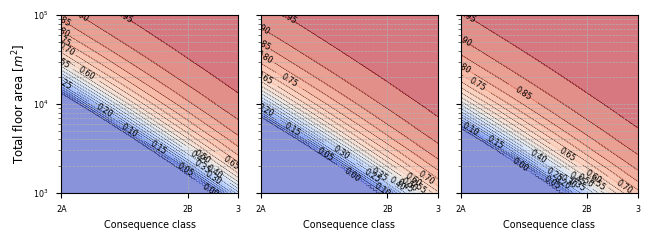

In [13]:
# define p parameters
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1),
}

# calculate time equivalence
teqs_no_sprinklers = dict()
for i, case in enumerate(cases_to_run):
    teq_cdf = func_A2cdf(A=area, beta=beta, **dict_p_i[case])
    teq_cdf[teq_cdf<0] = 0
    teqs_no_sprinklers[case] = teq_cdf

# visualisation, logscale
teqs = teqs_no_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.5), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)
for i, key in enumerate(teqs):
    ax = axes[i]
    cf = plot_contour(
        ax=ax, xx=beta, yy=area, zz=teqs[key], xlabel = 'Consequence class', 
        xticks=[3.7, 4.2, 4.4], xticklabels=['2A', '2B', '3'], 
        legend_visible=False, levels=np.linspace(0, 1, 21), clabel_fmt=lambda x: f'{x:.2f}', cmap='coolwarm'
    )

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='small')
axes[0].set_yscale('log')
plt.tight_layout()

### Buildings with sprinklers

In [28]:
# define p parameters
dict_p_i_sprinklers = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=0.09),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
}

# calculate time equivalence
beta, area = np.meshgrid(np.linspace(3.7, 4.4, 200), np.linspace(1000, 100000, 200))
teqs_sprinklers = dict()
for i, case in enumerate(cases_to_run):
    teq_cdf = func_A2cdf(A=area, beta=beta, **dict_p_i_sprinklers[case])
    teq = dict_func_cdf2teq[case](teq_cdf)
    teq[teq_cdf<0] = 0.
    teqs_sprinklers[case] = teq

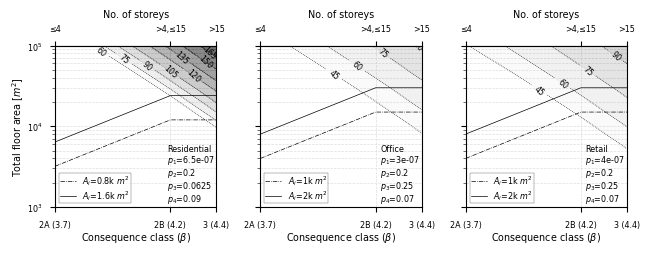

In [34]:
# visualisation, logscale
teqs = teqs_sprinklers
dict_p_i = dict_p_i_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.65), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)
for i, key in enumerate(teqs):
    levels = np.arange(60, 181, 15) if key == 'Residential' else np.arange(45, 181, 15)
    ax = axes[i]
    ax.set_yscale('log')
    
    # add line text
    if key == 'Residential':
        ax.plot([3.7, 4.2, 4.4], [j*800 for j in [4, 15, 15]], c='k', lw=.5, ls='-.', label='$A_i$=0.8k $m^2$')
        ax.plot([3.7, 4.2, 4.4], [j*1600 for j in [4, 15, 15]], c='k', lw=.5, ls='-', label='$A_i$=1.6k $m^2$')
    elif key == 'Office':
        ax.plot([3.7, 4.2, 4.4], [j*1000 for j in [4, 15, 15]], c='k', lw=.5, ls='-.', label='$A_i$=1k $m^2$')
        ax.plot([3.7, 4.2, 4.4], [j*2000 for j in [4, 15, 15]], c='k', lw=.5, ls='-', label='$A_i$=2k $m^2$')
    elif key == 'Retail':
        ax.plot([3.7, 4.2, 4.4], [j*1000 for j in [4, 15, 15]], c='k', lw=.5, ls='-.', label='$A_i$=1k $m^2$')
        ax.plot([3.7, 4.2, 4.4], [j*2000 for j in [4, 15, 15]], c='k', lw=.5, ls='-', label='$A_i$=2k $m^2$')
    
    # clabel locations, i.e. clabel_manual
    if key == 'Residential':
        teq_and_beta = ((60, 3.9), (75, 4.0), (90, 4.1), (105, 4.2), (120, 4.3), (135, 4.25), (150, 4.35), (165, 4.37))
    else:
        teq_and_beta = ((45, 4.02), (60, 4.12), (75, 4.23), (90, 4.35))
    clabel_manual = list()
    for teq_, beta_ in teq_and_beta:
        aa = stats.norm(loc=0, scale=1).cdf(-beta_)
        bb = np.prod(list(dict_p_i[key].values())) * (1 - dict_func_teq2cdf[key](teq_))
        clabel_manual.append((beta_, aa/bb))
    
    cf = plot_contour(
        ax=ax, xx=beta, yy=area, zz=teqs[key], xlabel = r'Consequence class ($\beta$)', xlabel_fontsize='xx-small', levels=levels,
        xticks=[3.7, 4.2, 4.4], xticklabels=['2A (3.7)', '2B (4.2)', '3 (4.4)'], ticks_labelsize='xx-small',
        legend_visible=True, legend_loc='lower left', legend_borderpad=0.1, legend_labelspacing=.1,
        clabel_manual=clabel_manual
    )
    ax.set_axisbelow(True)
    ax.set_xlabel(r'Consequence class ($\beta$)', fontsize='x-small', labelpad=1)
    
    plot_contour_text_p_i(ax=ax, title=key, p_i=dict_p_i[key], ha='right', va='bottom', x=0.99, y=0.01, bbox_pad=0.4, bbox_fc=(0,0,0,0), linespacing=1.0)
    
    ax2 = ax.secondary_xaxis('top')
    ax2.set_xlabel('No. of storeys', fontsize='x-small', labelpad=5)
    ax2.tick_params(labelsize='xx-small')
    ax2.set_xticks([3.7, 4.2, 4.4])
    ax2.set_xticklabels(['≤4', '>4,≤15', '>15'])

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='x-small', labelpad=1)
axes[0].set_yscale('log')

savefig(fig, 'contour_2_logscale.png')

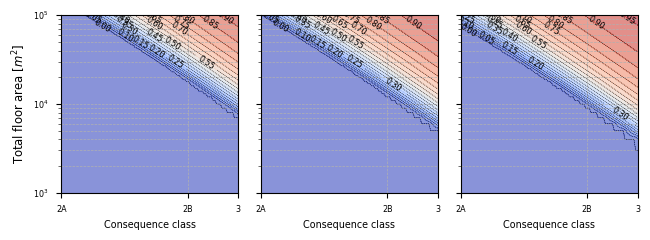

In [16]:
# define p parameters
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=0.09),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
}

# calculate time equivalence
beta, area = np.meshgrid(np.linspace(3.7, 4.4, 100), np.linspace(1000, 100000, 100))
teqs_sprinklers = dict()
for i, case in enumerate(cases_to_run):
    teq_cdf = func_A2cdf(A=area, beta=beta, **dict_p_i[case])
    teq_cdf[teq_cdf<0] = 0
    teqs_sprinklers[case] = teq_cdf

# visualisation, logscale
teqs = teqs_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.5), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)
for i, key in enumerate(teqs):
    ax = axes[i]
    cf = plot_contour(
        ax=ax, xx=beta, yy=area, zz=teqs[key], xlabel = 'Consequence class', 
        xticks=[3.7, 4.2, 4.4], xticklabels=['2A', '2B', '3'], 
        legend_visible=False, 
        levels=np.linspace(0, 1, 21), 
        clabel_fmt=lambda x: f'{x:.2f}', cmap='coolwarm'
    )

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='small')
axes[0].set_yscale('log')
plt.tight_layout()

### Comparing against BS 9999:2017

In [17]:
H_ = np.array([18, 30, 60, 100])
S_ = np.ceil((H_-3.3) / 3.3)


def func_FR(A, beta, p_i, func_cdf2teq, min_v=60):
    teq_cdf = func_A2cdf(A=A, beta=beta, **p_i)
    teq = func_cdf2teq(teq_cdf)
    teq[teq_cdf<0] = 0
    teq = np.ceil(teq/15.)*15.
    teq[teq==0] = min(min_v, *teq[teq>0])
    
    return teq

dict_p_i_1 = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1.),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1.),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1.),
}
dict_p_i_2 = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=0.09),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
}

betas = np.array([3.7, 4.2, 4.4, 4.4])
Ss = np.array([4, 15, 15, 30])

header = ["Method",    "Occupancy",  "Sprinkler", "A [m²]",    ">5, ≤18 m",   ">18, ≤30 m",   ">30 m",   "100 m"]

l1 =     ["BS 9999",  "Residential", False,       np.nan, 60,       90,       120,      120]
l11 =    ["SFEPRAPY", "Residential", False,       800,   *func_FR(800 * Ss, betas, dict_p_i_1['Residential'], dict_func_cdf2teq['Residential'])]
l12 =    ["SFEPRAPY", "Residential", False,       1600,  *func_FR(1600 * Ss, betas, dict_p_i_1['Residential'], dict_func_cdf2teq['Residential'])]

l2 =     ["BS 9999",  "Residential", True,        np.nan, 60,       60,       120,      120]
l21 =    ["SFEPRAPY", "Residential", True,        800,   *func_FR(800 * Ss, betas, dict_p_i_2['Residential'], dict_func_cdf2teq['Residential'])]
l22 =    ["SFEPRAPY", "Residential", True,        1600,  *func_FR(1600 * Ss, betas, dict_p_i_2['Residential'], dict_func_cdf2teq['Residential'])]

l3 =     ["BS 9999",  "Office",      False,       np.nan, 60,       90,       120,      120]
l31 =    ["SFEPRAPY", "Office",      False,       1000,   *func_FR(1000 * Ss, betas, dict_p_i_1['Office'], dict_func_cdf2teq['Office'], 45)]
l32 =    ["SFEPRAPY", "Office",      False,       2000,   *func_FR(2000 * Ss, betas, dict_p_i_1['Office'], dict_func_cdf2teq['Office'], 45)]

l4 =     ["BS 9999",  "Office",      True,        np.nan, 30,       60,       120,      120]
l41 =    ["SFEPRAPY", "Office",      True,        1000,   *func_FR(1000 * Ss, betas, dict_p_i_2['Office'], dict_func_cdf2teq['Office'], 45)]
l42 =    ["SFEPRAPY", "Office",      True,        2000,   *func_FR(2000 * Ss, betas, dict_p_i_2['Office'], dict_func_cdf2teq['Office'], 45)]

l5 =     ["BS 9999",  "Retail",      False,       np.nan, 60,       90,       120,      120]
l51 =    ["SFEPRAPY", "Retail",      False,       1000,   *func_FR(1000 * Ss, betas, dict_p_i_1['Retail'], dict_func_cdf2teq['Retail'], 45)]
l52 =    ["SFEPRAPY", "Retail",      False,       2000,   *func_FR(2000 * Ss, betas, dict_p_i_1['Retail'], dict_func_cdf2teq['Retail'], 45)]

l6 =     ["BS 9999",  "Retail",      True,        np.nan, 60,       60,       120,      120]
l61 =    ["SFEPRAPY", "Retail",      True,        1000,   *func_FR(1000 * Ss, betas, dict_p_i_2['Retail'], dict_func_cdf2teq['Retail'], 45)]
l62 =    ["SFEPRAPY", "Retail",      True,        2000,   *func_FR(2000 * Ss, betas, dict_p_i_2['Retail'], dict_func_cdf2teq['Retail'], 45)]

results = pd.DataFrame([l1, l11, l12, l2, l21, l22, l3, l31, l32, l4, l41, l42, l5, l51, l52, l6, l61, l62], columns=header)

In [18]:
print_df(results)

,Method,Occupancy,Sprinkler,A [m²],">5, ≤18 m",">18, ≤30 m",>30 m,100 m
0,BS 9999,Residential,False,NaN,60.0,90.0,120.0,120.0
1,SFEPRAPY,Residential,False,800.0,60.0,165.0,195.0,225.0
2,SFEPRAPY,Residential,False,1600.0,60.0,195.0,225.0,255.0
3,BS 9999,Residential,True,NaN,60.0,60.0,120.0,120.0
4,SFEPRAPY,Residential,True,800.0,60.0,60.0,90.0,120.0
5,SFEPRAPY,Residential,True,1600.0,60.0,75.0,120.0,150.0
6,BS 9999,Office,False,NaN,60.0,90.0,120.0,120.0
7,SFEPRAPY,Office,False,1000.0,45.0,90.0,105.0,120.0
8,SFEPRAPY,Office,False,2000.0,45.0,105.0,120.0,135.0
9,BS 9999,Office,True,NaN,30.0,60.0,120.0,120.0


end